## 数据预处理
数据来源：https://www.10xgenomics.com/datasets/xenium-protein-ffpe-human-renal-carcinoma

In [2]:
import h5py
import numpy as np
from scipy import sparse
import pandas as pd
from scipy.sparse import csc_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import tifffile
import os
from PIL import Image
from tqdm import tqdm

In [3]:
h5_path = "./data/cell_feature_matrix.h5"

In [4]:
with h5py.File(h5_path, "r") as f:
    def print_structure(name, obj):
        print(name)
    f.visititems(print_structure)

matrix
matrix/barcodes
matrix/data
matrix/features
matrix/features/_all_tag_keys
matrix/features/feature_type
matrix/features/genome
matrix/features/id
matrix/features/name
matrix/indices
matrix/indptr
matrix/shape


In [5]:
with h5py.File(h5_path, "r") as f:
    ## load sparse matrix
    data = f["matrix/data"][:]
    indices = f["matrix/indices"][:]
    indptr = f["matrix/indptr"][:]
    shape = tuple(f["matrix/shape"][:])  # (n_features x n_cells)

    ## load feature info
    feature_names = [x.decode() for x in f["matrix/features/name"][:]]
    feature_ids = [x.decode() for x in f["matrix/features/id"][:]]
    feature_types = [x.decode() for x in f["matrix/features/feature_type"][:]]
    barcodes = [x.decode() for x in f["matrix/barcodes"][:]]

print(shape)

(np.int32(543), np.int32(465545))


In [6]:
## load expression matrix
expr_matrix = csc_matrix((data, indices, indptr), shape=shape)
print("Shape of matrix (features x cells):", expr_matrix.shape)

Shape of matrix (features x cells): (543, 465545)


In [7]:
protein_idx = [i for i, ft in enumerate(feature_types) if ft == "Protein Expression"]
protein_names = [feature_names[i] for i in protein_idx]

ki67_idx_in_protein = protein_names.index("Ki-67")
ki67_feature_index = protein_idx[ki67_idx_in_protein]

print("Ki-67 feature row index:", ki67_feature_index)  

Ki-67 feature row index: 534


In [8]:
## extract Ki-67 expression matrix
ki67_expr = expr_matrix[ki67_feature_index, :].toarray().ravel()

print("Ki-67 表达 shape:", ki67_expr.shape)      
print("非零表达细胞数:", (ki67_expr > 0).sum())  

Ki-67 表达 shape: (465545,)
非零表达细胞数: 33459


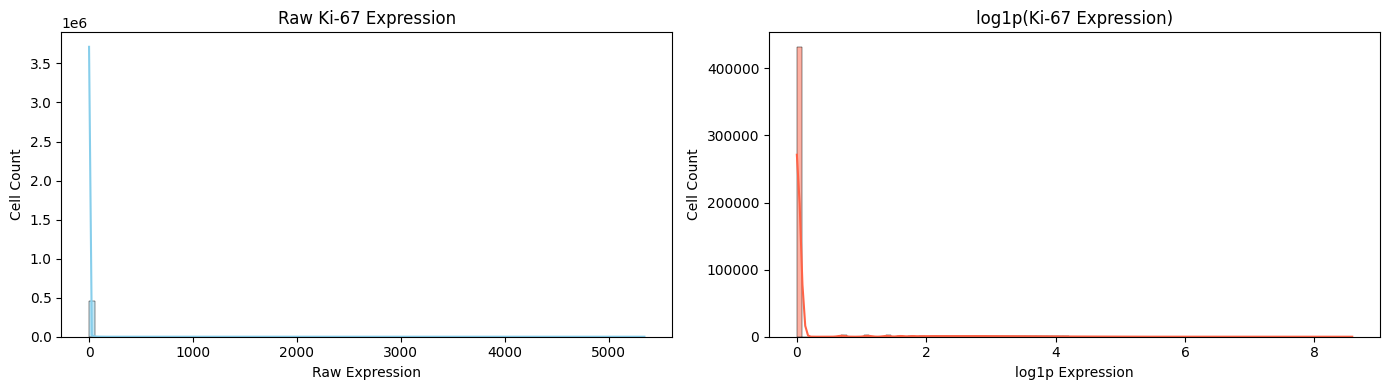

In [9]:
## 可视化Ki-67的表达分布
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(ki67_expr, bins=100, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Raw Ki-67 Expression")
axes[0].set_xlabel("Raw Expression")
axes[0].set_ylabel("Cell Count")

sns.histplot(np.log1p(ki67_expr), bins=100, kde=True, ax=axes[1], color='tomato')
axes[1].set_title("log1p(Ki-67 Expression)")
axes[1].set_xlabel("log1p Expression")
axes[1].set_ylabel("Cell Count")

plt.tight_layout()
plt.show()

In [10]:
## 设定Ki-67表达量>0为dividing类，反之为non-dividing类
labels = (ki67_expr > 0).astype(int) 

cell_labels = pd.DataFrame({
    "barcode": barcodes,
    "Ki67_expr": ki67_expr,
    "dividing_label": labels
})

print(cell_labels["dividing_label"].value_counts())

## save
cell_labels.to_csv("./result/cell_labels_with_ki67.csv", index=False)

dividing_label
0    432086
1     33459
Name: count, dtype: int64


In [11]:
## 读取细胞位置文件
table = pq.read_table("./data/cells.parquet")
cells_df = table.to_pandas()
print(cells_df.head())

      cell_id  x_centroid   y_centroid  transcript_counts  \
0  aaaacegh-1   36.700603  3494.752686                 67   
1  aaaaeiai-1   54.136509  3575.493896                 67   
2  aaaagkmn-1   49.582512  3534.720215                213   
3  aaaagncl-1   44.689571  3494.389160                 93   
4  aaaahjoa-1   19.052032  3595.543213                 39   

   control_probe_counts  genomic_control_counts  control_codeword_counts  \
0                     0                       0                        0   
1                     0                       0                        0   
2                     0                       0                        0   
3                     0                       0                        0   
4                     0                       0                        0   

   unassigned_codeword_counts  deprecated_codeword_counts  total_counts  \
0                           0                           0            67   
1                         

In [12]:
print(table.schema)

cell_id: large_string
x_centroid: double
y_centroid: double
transcript_counts: int64
control_probe_counts: int64
genomic_control_counts: int64
control_codeword_counts: int64
unassigned_codeword_counts: int64
deprecated_codeword_counts: int64
total_counts: int64
cell_area: double
nucleus_area: double
nucleus_count: int64
segmentation_method: large_string


In [13]:
## 根据barcode来合并细胞周期标签和细胞位置
# 统一barcode name
cells_df_renamed = cells_df.rename(columns={"cell_id": "barcode"})

# 合并 Ki-67 label
merged_df = pd.merge(cells_df_renamed, cell_labels, on="barcode", how="inner")

print("合并后行数：", len(merged_df))
print(merged_df[["barcode", "x_centroid", "y_centroid", "dividing_label", "Ki67_expr"]].head())


合并后行数： 465545
      barcode  x_centroid   y_centroid  dividing_label  Ki67_expr
0  aaaacegh-1   36.700603  3494.752686               1          7
1  aaaaeiai-1   54.136509  3575.493896               0          0
2  aaaagkmn-1   49.582512  3534.720215               1         40
3  aaaagncl-1   44.689571  3494.389160               0          0
4  aaaahjoa-1   19.052032  3595.543213               0          0


In [ ]:
## 导入图像
with tifffile.TiffFile('./data/ch0000_dapi.ome.tif') as tif:
    print(f"图像共有 {len(tif.pages)} 层") ## 一层
    dapi_img = tif.pages[0].asarray()  
    print("读取图像形状：", dapi_img.shape)

图像共有 1 层
读取图像形状： (27328, 54002)


In [15]:
## 查看DAPI图的metadata
mipurl = './data/ch0000_dapi.ome.tif'

with tifffile.TiffFile(mipurl) as tif:
    for tag in tif.pages[0].tags.values():
        if tag.name == 'ImageDescription':
            print(tag.name+":", tag.value)

ImageDescription: <OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd" UUID="urn:uuid:ba5c30ca-6280-11f0-83e0-3cecefaf452c">
  <Plate ID="Plate:0" WellOriginX="0.0" WellOriginXUnit="µm" WellOriginY="0.0" WellOriginYUnit="µm"/>
  <Instrument ID="Instrument:0">
    <Microscope Manufacturer="10x Genomics" Model="Xenium"/>
  </Instrument>
  <Image ID="Image:0">
    <InstrumentRef ID="Instrument:0"/>
    <Pixels ID="Pixels:0" DimensionOrder="XYZCT" Type="uint16" SizeX="54002" SizeY="27328" SizeZ="1" SizeC="35" SizeT="1" PhysicalSizeX="0.2125" PhysicalSizeXUnit="µm" PhysicalSizeY="0.2125" PhysicalSizeYUnit="µm">
      <Channel ID="Channel:0" Name="DAPI" SamplesPerPixel="1">
        <AnnotationRef ID="Annotation:0"/>
      </Channel>
      <Channel ID="Channel:1" Name="ATP1A1/CD45/E-Cadherin" SamplesPer

In [18]:
## scale_factor设置为0.2125(参考：https://kb.10xgenomics.com/hc/en-us/articles/11636252598925-What-are-the-Xenium-image-scale-factors?utm_source=chatgpt.com)
## Patch提取+归一化+保存成训练数据
def extract_and_save_dapi_patches_to_hdf5(
    dapi_img, 
    merged_df, 
    patch_um=20, 
    scale=0.2125, 
    out_path="./result/dapi_patches_20um.h5", 
    normalize=True,
    label_dtype="i1"  # 存储 label 用 int8（节省空间）
):
    patch_size = int(patch_um / scale)
    half_size = patch_size // 2

    # 坐标转换
    merged_df["x_px"] = (merged_df["x_centroid"] / scale).round().astype(int)
    merged_df["y_px"] = (merged_df["y_centroid"] / scale).round().astype(int)

    patches = []
    labels = []
    barcodes = []

    for i, row in tqdm(merged_df.iterrows(), total=len(merged_df)):
        x, y = row["x_px"], row["y_px"]
        label = row["dividing_label"]
        
        if (
            x - half_size < 0 or x + half_size >= dapi_img.shape[1] or
            y - half_size < 0 or y + half_size >= dapi_img.shape[0]
        ):
            continue
        
        patch = dapi_img[y - half_size : y + half_size, x - half_size : x + half_size]
        
        if normalize:
            patch = patch.astype(np.float32)
            patch -= patch.min()
            patch /= (patch.max() + 1e-5)
        
        patches.append(patch.astype(np.float32))
        labels.append(int(label))
        barcodes.append(row["barcode"])

    # === 保存为 HDF5 ===
    patches = np.stack(patches)  # (N, H, W)
    labels = np.array(labels, dtype=label_dtype)
    barcodes = np.array(barcodes, dtype=h5py.string_dtype(encoding='utf-8'))

    with h5py.File(out_path, "w") as f:
        f.create_dataset("images", data=patches, compression="gzip")
        f.create_dataset("labels", data=labels)
        f.create_dataset("barcodes", data=barcodes)
    
    print(f"✅ 已保存 {len(patches)} 个 patch 到 HDF5 文件：{out_path}")
    print(f"HDF5 中图像 shape: {patches.shape}, 标签 shape: {labels.shape}")

In [19]:
## 保存图像
extract_and_save_dapi_patches_to_hdf5(
    dapi_img=dapi_img,
    merged_df=merged_df,
    patch_um=20,
    out_path="./result/dapi_patches_20um.h5"
)

100%|██████████| 465545/465545 [00:42<00:00, 10993.98it/s]


✅ 已保存 464732 个 patch 到 HDF5 文件：./result/dapi_patches_20um.h5
HDF5 中图像 shape: (464732, 94, 94), 标签 shape: (464732,)


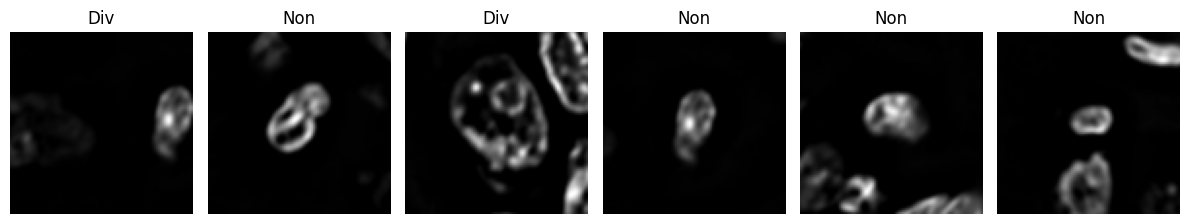

In [24]:
## 读取显示一个图像
patch_path = "./result/dapi_patches_20um.h5"

# 显示前 6 张图像
with h5py.File(patch_path, "r") as f:
    imgs = f["images"][:6]
    labels = f["labels"][:6]

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(imgs[i], cmap="gray")
    plt.title(f"{'Div' if labels[i]==1 else 'Non'}")
    plt.axis("off")
plt.tight_layout()
plt.show()